## Text Classification by Hugging Face Pre Trained Model

In [34]:
!pip install pandas torch scipy transformers scikit-learn matplotlib seaborn numpy pyarrow mlflow evaluate

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [146]:
import numpy as np
import os
import pandas as pd
import json

from scipy.stats import percentileofscore
from sklearn.model_selection import train_test_split

from transformers import (
    BartForConditionalGeneration, 
    BartTokenizer, 
    AutoModelForSequenceClassification, 
    AutoTokenizer, 
    Trainer, 
    TrainingArguments, 
    pipeline
)
from datasets import Dataset
from huggingface_hub import list_repo_refs , create_repo

import matplotlib.pyplot as plt
import mlflow
import seaborn as sns
import evaluate

device = 'cuda'
base_model_name = "distilbert-base-uncased"
hf_user = "ruban19"
hf_token = "xx"
mlflow_token = 'xx'

In [147]:
os.environ['WANDB_MODE'] = 'disabled'
os.environ['WANDB_DISABLED'] = 'true'
os.environ['MLFLOW_TRACKING_USERNAME'] = 'ruban.kumar'
os.environ['MLFLOW_TRACKING_PASSWORD'] = mlflow_token
os.environ['MLFLOW_TRACKING_PROJECTNAME'] = 'text-classification'

In [37]:
# By default, the pipeline runs on the CPU (device=-1). Set device to 0 to use the GPU (and to 1 for the second GPU, etc...)
classifier = pipeline("zero-shot-classification", device=device)
classifier(
    ["Parallel processing with GPUs is the savior of Deep Learning","Masters is a good way to get into academia research."],
    candidate_labels=["education", "politics", "technology"],
)

No model was supplied, defaulted to facebook/bart-large-mnli and revision c626438 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


[{'sequence': 'Parallel processing with GPUs is the savior of Deep Learning',
  'labels': ['technology', 'education', 'politics'],
  'scores': [0.9941806197166443, 0.003100931877270341, 0.0027184500358998775]},
 {'sequence': 'Masters is a good way to get into academia research.',
  'labels': ['education', 'technology', 'politics'],
  'scores': [0.9170135855674744, 0.05939773842692375, 0.02358863316476345]}]

The classifier guessed that the sentence is about tech with a probability over 99%. **But how does Zero-Shot classification compare with plain "old" fine-tuned text classification?**

## 1) BBC News dataset

Let's build a classifier of news articles labeled *business*, *entertainment*, *politics*, *sport* and *tech*. The dataset consists of 2225 documents from the BBC news website from the years 2004/2005.


In [112]:
labels= ['entertainment', 'business', 'sport', 'politics', 'tech']
id2label = dict(enumerate(labels))
label2id = {v: k for k, v in id2label.items()}

In [113]:
df = pd.read_csv("/kaggle/input/d/alfathterry/bbc-full-text-document-classification/bbc_data.csv")
df = df.rename(columns={'labels' : 'category' , 'data' : 'article'})
df.head()

,article,category
0,Musicians to tackle US red tape Musicians gro...,entertainment
1,"U2s desire to be number one U2, who have won ...",entertainment
2,Rocker Doherty in on-stage fight Rock singer ...,entertainment
3,Snicket tops US box office chart The film ada...,entertainment
4,"Oceans Twelve raids box office Oceans Twelve,...",entertainment


In [114]:
df.shape

(2225, 2)

In [115]:
# Number of articles per label
df.value_counts('category')

category
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64

We will need integer labels to feed the transformer model:

In [118]:
df['label'] = df['category'].map(label2id)

Here are 5 random rows from the final dataframe:

In [119]:
df.sample(5, random_state=42)

,article,category,label
414,China now top trader with Japan China overtoo...,business,1
420,Bush budget seeks deep cutbacks President Bus...,business,1
1644,MPs murder sentence concern Murder sentences ...,politics,3
416,GE sees excellent world economy US behemoth G...,business,1
1232,Rush future at Chester uncertain Ian Rushs fu...,sport,2


In [62]:
# df= df[:20]

## 2) Fine-tuning a pretrained text classifier

After building the train/validation/test sets, we will go straight the point by using the [`DistilBERT`](https://huggingface.co/transformers/model_doc/distilbert.html) pre-trained transformer model (and its tokenizer).

> *It is a small, fast, cheap and light Transformer model trained by distilling BERT base. It has 40% less parameters than bert-base-uncased, runs 60% faster while preserving over 95% of BERT’s performances.* 

In [120]:
# Train set, validation set and test set
train_val, test = train_test_split(df, test_size=0.1, random_state=42, shuffle=True)
train, val = train_test_split(train_val, test_size=0.1, random_state=42, shuffle=True)

# Reset the indexes of the 3 pandas.DataFrame()
train, val, test = map(lambda x:x.reset_index(drop=True), [train, val, test])

In [121]:
print(json.dumps({
    'train size' : train.shape,
    'test_size' : test.shape,
    'validation' : val.shape
}, indent=4))

{
    "train size": [
        1801,
        3
    ],
    "test_size": [
        223,
        3
    ],
    "validation": [
        201,
        3
    ]
}


#### Tokenize

Loading DistilBERT's tokenizer, we can see that this transformer model takes input sequences composed of up to 512 tokens: 

In [122]:
# Load Distilbert's tokenizer
tokenizer = AutoTokenizer.from_pretrained(base_model_name)

In [123]:
tokenizer.model_max_length

512

How does this compare with the lengths of the tokenized BBC articles?

In [124]:
tokenized_articles_lengths=pd.DataFrame(
    {
        'length': list(map(len, tokenizer(df['article'].to_list(), truncation=False, padding=False)['input_ids']))
    }
)
tokenized_articles_lengths.describe()

Token indices sequence length is longer than the specified maximum sequence length for this model (1033 > 512). Running this sequence through the model will result in indexing errors


,length
count,2225.000000
mean,481.089888
std,288.862706
min,106.000000
25%,310.000000
50%,417.000000
75%,585.000000
max,5217.000000


The articles are, on average, 482-token-long. The longest news is composed of 5217 tokens. This means that an important part of the articles will be truncated before being fed to the transformer model. Here is the distribution of the lengths:

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


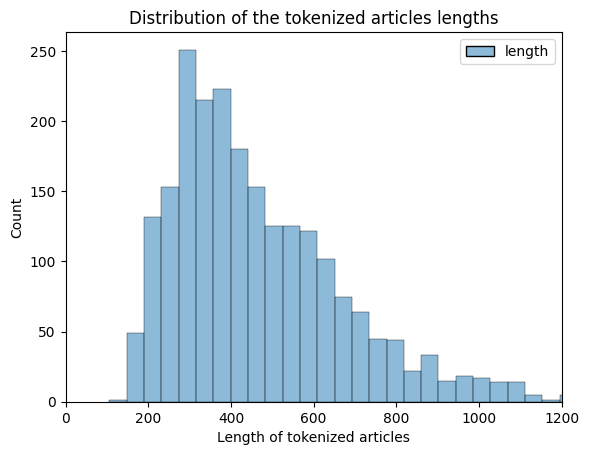

In [125]:
ax=sns.histplot(tokenized_articles_lengths)
ax.set(xlabel='Length of tokenized articles', ylabel='Count', xlim=(0, 1200), title='Distribution of the tokenized articles lengths')
plt.show()

In [126]:
print(f'Percentile of length=512: {int(percentileofscore(tokenized_articles_lengths["length"],512))}th')

Percentile of length=512: 64th


About 40% of the articles will be truncated to fit the 512-token limit of DistilBERT. The truncation is mandatory, otherwise the model crashes. We will use fixed padding for the sake of simplicity here.

#### Fine-tune DistilBERT

The train/validation/test sets must be procesμsed to work with either PyTorch or TensorFlow.

In [127]:
train_dataset = Dataset.from_pandas(train)
test_dataset = Dataset.from_pandas(test)
val_dataset = Dataset.from_pandas(val)


def tokenize(examples):
    return tokenizer(examples["article"], truncation=True, max_length=512)

In [128]:
train_tokenized_dataset = train_dataset.map(tokenize, batched=True).remove_columns(['article','category'])
test_tokenized_dataset = test_dataset.map(tokenize, batched=True).remove_columns(['article','category'])
val_tokenized_dataset = val_dataset.map(tokenize, batched=True).remove_columns(['article','category'])

Map:   0%|          | 0/1801 [00:00<?, ? examples/s]

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/201 [00:00<?, ? examples/s]

In [129]:
print(train_tokenized_dataset[0].keys())

dict_keys(['label', 'input_ids', 'attention_mask'])


In [130]:
# The number of predicted labels must be specified with num_labels # .to('cuda') to do the training on the GPU
model = AutoModelForSequenceClassification.from_pretrained(base_model_name, num_labels=len(labels), id2label=id2label,label2id=label2id).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [131]:
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [135]:

repo_name = f"{hf_user}/{base_model_name}-finetuned-news"

try :
    branches = list_repo_refs(repo_name, repo_type="model",token = hf_token)
    final_branches = []
    for branch in branches.branches:
        final_branches.append(branch.name)
    if sorted(final_branches)[-1] == 'main':
        model_version = 'v1'
    else:
        model_version = "v" + str(int(sorted(final_branches)[-1][-1]) + 1)
except Exception as e:
    create_repo(repo_name,repo_type='model',token = hf_token)
    model_version = 'main'

# Fine-tuning
training_args = TrainingArguments(
    output_dir="./output",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    num_train_epochs=5,
    logging_steps=20,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    report_to=None,
)

trainer = Trainer(
    model=model,                         
    args=training_args,                  
    train_dataset=train_tokenized_dataset, 
    eval_dataset=val_tokenized_dataset ,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics              
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [136]:
mlflow.set_registry_uri("xx")
mlflow.set_tracking_uri("xx")
mlflow.enable_system_metrics_logging()
mlflow.transformers.autolog(log_datasets=True,log_models=True)

In [137]:
experiment_name = 'Text-Classification [Hugging Face]'

try:
    # Attempt to get the experiment by name
    experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id
except AttributeError:
    # If getting the experiment raises an AttributeError, create a new one
    experiment_id = mlflow.create_experiment(experiment_name)
    
print(experiment_id)

21


In [138]:

mlflow.start_run(experiment_id=experiment_id)

mlflow.log_params(
        {
            "Model Repo Name": repo_name,
            "Base Model Name": base_model_name,
            "Model Version": model_version,
        }
    )
components = {
    "model": model,
    "tokenizer": tokenizer,
}
mlflow.transformers.log_model(
    transformers_model=components,
    artifact_path="my_model",
)
history = trainer.train()

2024/08/13 20:38:33 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.138200,0.144863,0.975124
2,0.170500,0.239253,0.955224
3,0.033600,0.185633,0.970149
4,0.023000,0.177390,0.970149
5,0.000700,0.162249,0.970149


In [139]:
model.push_to_hub(repo_id=repo_name,commit_message="Training complete!",revision = model_version, token = hf_token)
tokenizer.push_to_hub(repo_id=repo_name,commit_message="Training complete!",revision = model_version, token = hf_token)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/ruban19/distilbert-base-uncased-finetuned-news/commit/86a6e7c7dd7bcedca8282644b1a90525310e67f3', commit_message='Training complete!', commit_description='', oid='86a6e7c7dd7bcedca8282644b1a90525310e67f3', pr_url=None, pr_revision=None, pr_num=None)

In [141]:
history

TrainOutput(global_step=1130, training_loss=0.07536298893804176, metrics={'train_runtime': 277.3114, 'train_samples_per_second': 32.473, 'train_steps_per_second': 4.075, 'total_flos': 1189316087311860.0, 'train_loss': 0.07536298893804176, 'epoch': 5.0})

In [142]:
# Generate predictions for the test set
predictions=trainer.predict(test_tokenized_dataset)

#### Accuracy

In [90]:
test_results=test.copy(deep=True)
test_results["label_int_pred_transfer_learning"]=np.argmax(predictions.predictions, axis=-1)
test_results['label_pred_transfer_learning']=test_results['label_int_pred_transfer_learning'].apply(lambda x:labels[x])
test_results

,article,category,label,label_int_pred_transfer_learning,label_pred_transfer_learning
0,China now top trader with Japan China overtoo...,business,1,1,business
1,Bush budget seeks deep cutbacks President Bus...,business,1,1,business
2,MPs murder sentence concern Murder sentences ...,politics,3,3,politics
3,GE sees excellent world economy US behemoth G...,business,1,1,business
4,Rush future at Chester uncertain Ian Rushs fu...,sport,2,2,sport
...,...,...,...,...,...
218,Ten-year tragedy of missing Manic Richey Edwa...,entertainment,0,0,entertainment
219,US woman sues over cartridges A US woman is s...,tech,4,4,tech
220,"Oceans Twelve raids box office Oceans Twelve,...",entertainment,0,0,entertainment
221,Veteran comic Cyril Fletcher dies Veteran com...,entertainment,0,0,entertainment


In [91]:
accuracy=1-(len(test_results[test_results["label"]!=test_results["label_int_pred_transfer_learning"]])/len(test_results))
mlflow.log_metric("accuracy", accuracy)
print(f'The accuracy of the fine-tuned DistilBERT transformer model on the test set is {100*accuracy:.2f}%.')
mlflow.end_run()

The accuracy of the fine-tuned DistilBERT transformer model on the test set is 98.65%.


#### Misclassified articles

In [92]:
with pd.option_context('display.max_colwidth', None):
    display(test_results[test_results["label"]!=test_results["label_int_pred_transfer_learning"]])

,article,category,label,label_int_pred_transfer_learning,label_pred_transfer_learning
58,"BBC should allow more scrutiny MPs have urged the BBC to give watchdogs more freedom to scrutinise how xc2xa32bn in licence fee money is spent. The Public Accounts Committee called for the National Audit Office to be given a ""free hand"" to investigate how the BBC offers value for money. Although six areas are to be opened up to scrutiny the audit office should have more power to choose what it investigated, the MPs said. The call was made in a report into the BBCs Freeview digital service. ""Our aim is not to rewrite the storyline of EastEnders but simply to ensure that the BBC is as accountable to parliament as any other organisation spending public money,"" said the committee chairman, MP Edward Leigh. ""The BBCs spending is not subject to the full independent scrutiny, and accountability to parliament. ""Parliament requires television owners to pay a licence fee and expects the comptroller and auditor general, on behalf of parliament, to be able to scrutinise how that money, over xc2xa32 billion a year, is used."" A BBC spokeswoman said: ""We share the committees interest in ensuring the public money we receive is spent well. Though in its infancy, we think the arrangements with the NAO are working well and should be given time to mature."" The report said the Freeview digital service has had an ""impressive"" take up since its launch but the BBC must still dispel confusion about the service. The committee found the BBC had succeeded in ensuring subscription-free access to digital channels following the collapse of ITV Digital in 2002. But the fact that one in four homes could not access Freeview remained a problem. The report said that while gaps in the coverage were largely due to landscape issues, there was need for detailed explanations on the Freeview website and on promotional literature as to why it was not available in specific areas. The government has proposed switch off of the analogue television signal, with 2012 the most recently proposed date. The BBC launched Freeview in 2002 as an alternative to satellite subscription services such as Sky, to allow its digital channels such as BBC Three and News 24 to be seen. There have been an estimated five million Freeview set-top boxes sold since the launch and prices have fallen considerably. The corporation plans to spend up to xc2xa3138m on Freeview before 2014 to ensure people can receive the service throughout the UK, and are aware of it.",entertainment,0,3,politics
115,"Ferdinand casts doubt over Glazer Rio Ferdinand has said he is unsure of Malcolm Glazers motives after the American billionaire launched a new offer to buy Manchester United. The club have confirmed that the Glazer Family Partnership have submitted proposals of a third bid. ""A lot of people want the clubs interest to be with people who have grown up with the club and have got its interests at heart,"" said Ferdinand. ""No one knows what this guy will be bringing to the table."" The central defender added on BBC Radio Five Live: ""We will have to wait and see what Glazer comes with. ""I would like to see the situation resolved either way. ""I think people are getting bored with him coming in and out of the news with new proposals. ""The other stuff off the pitch takes the shine off what is going on the pitch."" Glazer, currently owns a 28.1% stake in the club, and Uniteds statement to the stock exchange said: ""The board has noted the recent press speculation on this subject. ""The board can confirm that it has now received a detailed proposal subject to various pre-conditions which may form the basis of an offer for Manchester United from Glazer. ""A further announcement will be made in due course."" Glazers previous bids for the club, which United supporters opposed, were rejected by the board because of the high level of debt they would incur. But it is believed that Glazer has substantially reduced the b

There are only 3 errors on the test set, out of 223 articles. 

## 3) Zero-Shot Classification

We'll use the appropriate [`transformers.pipeline`](https://huggingface.co/transformers/main_classes/pipelines.html) to compute the predicted class for each article.

In [93]:
classifier = pipeline("zero-shot-classification", device=device) # device=0 means GPU

No model was supplied, defaulted to facebook/bart-large-mnli and revision c626438 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [94]:
# Compute the predicted label for each article
test_results['label_pred_zero_shot']=test_results['article'].apply(lambda x:classifier(x, candidate_labels=labels)['labels'][0])

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [95]:
# Reorder columns and save results
test_results=test_results[['article', 'category', 'label_pred_transfer_learning', 'label_pred_zero_shot']]
test_results

,article,category,label_pred_transfer_learning,label_pred_zero_shot
0,China now top trader with Japan China overtoo...,business,business,business
1,Bush budget seeks deep cutbacks President Bus...,business,business,politics
2,MPs murder sentence concern Murder sentences ...,politics,politics,politics
3,GE sees excellent world economy US behemoth G...,business,business,business
4,Rush future at Chester uncertain Ian Rushs fu...,sport,sport,business
...,...,...,...,...
218,Ten-year tragedy of missing Manic Richey Edwa...,entertainment,entertainment,entertainment
219,US woman sues over cartridges A US woman is s...,tech,tech,tech
220,"Oceans Twelve raids box office Oceans Twelve,...",entertainment,entertainment,entertainment
221,Veteran comic Cyril Fletcher dies Veteran com...,entertainment,entertainment,entertainment


In [96]:
error_rate=len(test_results[test_results["category"]!=test_results["label_pred_zero_shot"]])/len(test_results)
print(f'Accuracy of the Zero-Shot classifier: {round(100*(1-error_rate), 2)} %')

Accuracy of the Zero-Shot classifier: 62.78 %


The Zero-Shot classifier does a really bad job compared with the fine-tuned model. However, given the number of labels &mdash; 5 &mdash; this result is not that catastrophic. It is well above the 20% a random classifier would achieve (assuming balanced classes). Let's have a look at a few random articles uncorrectly labeled by the Zero-Shot classifier:

In [97]:
test_results[test_results["category"]!=test_results["label_pred_zero_shot"]].sample(15, random_state=42)

,article,category,label_pred_transfer_learning,label_pred_zero_shot
82,Eminem beats Elvis to number one Rapper Emine...,entertainment,entertainment,sport
1,Bush budget seeks deep cutbacks President Bus...,business,business,politics
60,Hobbit picture four years away Lord of the Ri...,entertainment,entertainment,business
87,Highbury tunnel players in clear The Football...,sport,sport,business
54,Borussia Dortmund near bust German football c...,business,business,sport
76,Police urge pub closure power New powers are ...,politics,politics,business
28,Mido makes third apology Ahmed Mido Hossam ha...,sport,sport,tech
141,Media seek Jackson juror notes Reporters cove...,entertainment,entertainment,business
13,Spears seeks aborted tour payment Singer Brit...,entertainment,entertainment,business
33,Dollar slides ahead of New Year The US dollar...,business,business,politics


There does not seem to be a particularly problematic class, although such a assertion would require further investigation. But the length of the news could lead to poor performance.

We'll try another solution: summarizing the article first, then Zero-Shot classifying it.

## 4) Summarization + Zero-Shot Classification

The easiest way to do this would have been to line up the `SummarizationPipeline` with the `ZeroShotClassificationPipeline`. This is not possible, at least with my version of the `transformers` library (3.5.1). The reason for this is that the `SummarizationPipeline` uses Facebook's BART model, whose maximal input length is 1024 tokens. However, `transformers`'s tokenizers, including `BartTokenizer`, do not automatically truncate sequences to the max input length of the corresponding model. As a consequence, the `SummarizationPipeline` crashes whenever sequences longer than 1024 tokens are given as inputs. Since there are quite a few long articles in the BBC dataset, we will have to make a custom summarization pipeline that truncates news longers than 1024 tokens.

In [98]:
# Import the tokenizer and model for summarization (the same that are used by default in Hugging Face's summarization pipeline)

model_bart = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn').to(device) # Run on the GPU
tokenizer_bart = BartTokenizer.from_pretrained('facebook/bart-large-cnn')

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [99]:
# Custom summarization pipeline (to handle long articles)
def summarize(text):
    # Tokenize and truncate
    inputs = tokenizer_bart([text], truncation=True, max_length=1024, return_tensors='pt').to(device)
    # Generate summary between 10 (by default) and 50 characters
    summary_ids = model_bart.generate(inputs['input_ids'], num_beams=4, max_length=60, early_stopping=True)
    # Untokenize
    return([tokenizer_bart.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_ids][0])

In [100]:
# Apply summarization then zero-shot classification to the test set
test_results['label_pred_sum_zs']=test_results['article'].apply(lambda x:classifier(summarize(x), candidate_labels=labels)['labels'][0])
test_results

/tmp/ipykernel_34/1103828682.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_results['label_pred_sum_zs']=test_results['article'].apply(lambda x:classifier(summarize(x), candidate_labels=labels)['labels'][0])


,article,category,label_pred_transfer_learning,label_pred_zero_shot,label_pred_sum_zs
0,China now top trader with Japan China overtoo...,business,business,business,business
1,Bush budget seeks deep cutbacks President Bus...,business,business,politics,politics
2,MPs murder sentence concern Murder sentences ...,politics,politics,politics,politics
3,GE sees excellent world economy US behemoth G...,business,business,business,business
4,Rush future at Chester uncertain Ian Rushs fu...,sport,sport,business,business
...,...,...,...,...,...
218,Ten-year tragedy of missing Manic Richey Edwa...,entertainment,entertainment,entertainment,tech
219,US woman sues over cartridges A US woman is s...,tech,tech,tech,tech
220,"Oceans Twelve raids box office Oceans Twelve,...",entertainment,entertainment,entertainment,entertainment
221,Veteran comic Cyril Fletcher dies Veteran com...,entertainment,entertainment,entertainment,entertainment


In [102]:
error_rate_sum_zs=len(test_results[test_results["category"]!=test_results["label_pred_sum_zs"]])/len(test_results)
print(f'Accuracy of the Summmarization+Zero-Shot classifier pipeline: {round(100*(1-error_rate_sum_zs), 2)} %')

Accuracy of the Summmarization+Zero-Shot classifier pipeline: 75.34 %


Adding the summarization before the zero-shot classification, **the accuracy jumped by ~15%**! Let us remember that there was no training whatsoever. From this perspective, a 75.34% accuracy looks pretty good. This result could probably be enhanced by tuning the summarizer's parameters regarding beam search or maximal length.

## 5) Model Inference

In [144]:
from transformers import pipeline 

finetuned_checkpoint = repo_name
model_version = 'main'
classifier = pipeline("text-classification", model=finetuned_checkpoint, revision=model_version)


classifier(["Life of PI is a good movie" ,"AI is gonna revolutionze the future computers and Software Industry"])

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'label': 'entertainment', 'score': 0.9956342577934265},
 {'label': 'tech', 'score': 0.9987155199050903}]

## 6) Conclusion

Text classification is a piece of cake using Hugging Face's pre-trained models: fine-tuning DistilBERT is fast (using a GPU), easy and it resulted in a 98.65% accuracy on the BBC News test set. Although this result should be confirmed with other train-test split (only 56 articles in the test set), it is absolutely remarkable. The raw Zero-Shot Classification pipeline from the `transformers` library could not compete at all with such a performance, ending up with a ~59% accuracy on the same test set. Nonetheless, this result is still decent considering the complete absence of training required by this method.  
  
Given the substantial length of the BBC News articles, we tried summarizing them before performing the Zero-Shot classification, still using the beloved `transformers` library. This method resulted in a +15% increase of accuracy. Another way would have been to carry out sentence segmentation before the Zero-Shot classification, and averaging the prediction over all an article's sentences.

We end up with two text classifiers:
* One that requires training and yields a 98.65% accuracy
* One that does not require any training, but yields a ~73.5% accuracy
